# Setup

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [3]:
image_path = '/kaggle/input/house-price-multimodal-dataset/images'
tabular_path = '/kaggle/input/house-price-multimodal-dataset/full_dataset.csv'

label = 'Price'

random_state = 13

# Dataset

In [4]:
df = pd.read_csv(tabular_path)
df.drop(columns=['Tipe Iklan', 'Tipe Properti'], inplace=True)

# Data Processing

In [8]:
# Compute Q1, Q3, and IQR
Q1 = df[label].quantile(0.25)
Q3 = df[label].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[label] < lower_bound) | (df[label] > upper_bound)]
df = df[(df[label] >= lower_bound) & (df[label] <= upper_bound)]

<Axes: xlabel='Price'>

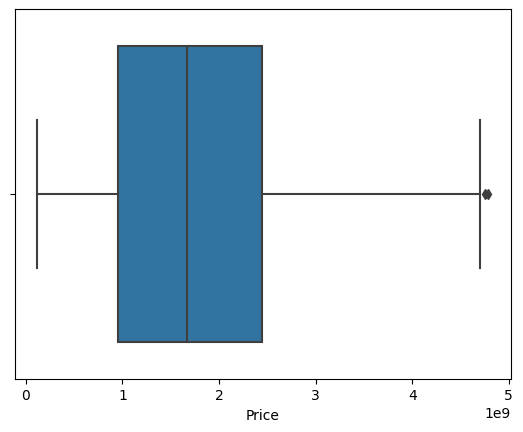

In [9]:
sns.boxplot(df, x=label)

In [10]:
# Handling Missing values
df.loc[df['Luas Bangunan'].isna(), 'Luas Bangunan'] = df['Luas Bangunan'].median()
df.loc[df['Luas Tanah'].isna(), 'Luas Tanah'] = df['Luas Tanah'].median()
df.loc[df['Daya Listrik'].isna(), 'Daya Listrik'] = df['Daya Listrik'].median()
df.loc[df['Tahun Dibangun'].isna(), 'Tahun Dibangun'] = df['Tahun Dibangun'].median()

df.loc[df['Kamar Tidur'].isna(), 'Kamar Tidur'] = df['Kamar Tidur'].mode()[0]
df.loc[df['Kamar Mandi'].isna(), 'Kamar Mandi'] = df['Kamar Mandi'].mode()[0]
df.loc[df['Carpots'].isna(), 'Carpots'] = df['Carpots'].mode()[0]
df.loc[df['Garasi'].isna(), 'Garasi'] = df['Garasi'].mode()[0]
df.loc[df['Sertifikat'].isna(), 'Sertifikat'] = df['Sertifikat'].mode()[0]
df.loc[df['Jumlah Lantai'].isna(), 'Jumlah Lantai'] = df['Jumlah Lantai'].mode()[0]

df.loc[df['Interior'].isna(), 'Interior'] = "Unknown"
df.loc[df['Orientasi Bangunan'].isna(), 'Orientasi Bangunan'] = "Unknown"
df.loc[df['Nama Perumahan'].isna(), 'Nama Perumahan'] = "Unknown"

df['District'] = df.groupby('City')['District'].transform(lambda x: x.fillna(x.mode()[0]))
df["Latitude"] = df.groupby("City")["Latitude"].transform(lambda x: x.fillna(x.mean()))
df["Longitude"] = df.groupby("City")["Longitude"].transform(lambda x: x.fillna(x.mean()))

df.loc[df['Orientasi Bangunan'] == '3', 'Orientasi Bangunan'] = 'Unknown'
df.loc[df['Orientasi Bangunan'] == '1', 'Orientasi Bangunan'] = 'Unknown'
df.loc[df['Orientasi Bangunan'] == '4', 'Orientasi Bangunan'] = 'Unknown'
df.loc[df['Orientasi Bangunan'] == '2', 'Orientasi Bangunan'] = 'Unknown'

# LE = LabelEncoder()

# df['Sertifikat'] = LE.fit_transform(df['Sertifikat'])
# df['Interior'] = LE.fit_transform(df['Interior'])
# df['Orientasi Bangunan'] = LE.fit_transform(df['Orientasi Bangunan'])
# df['Province'] = LE.fit_transform(df['Province'])
# df['City'] = LE.fit_transform(df['City'])
# df['District'] = LE.fit_transform(df['District'])
# df['Nama Perumahan'] = LE.fit_transform(df['Nama Perumahan'])

In [11]:
# Initialize a LabelEncoder for each column
le_sertifikat = LabelEncoder()
le_interior = LabelEncoder()
le_orientasi = LabelEncoder()
le_province = LabelEncoder()
le_city = LabelEncoder()
le_district = LabelEncoder()
le_perumahan = LabelEncoder()

# Fit and transform each column
df['Sertifikat'] = le_sertifikat.fit_transform(df['Sertifikat'])
df['Interior'] = le_interior.fit_transform(df['Interior'])
df['Orientasi Bangunan'] = le_orientasi.fit_transform(df['Orientasi Bangunan'])
df['Province'] = le_province.fit_transform(df['Province'])
df['City'] = le_city.fit_transform(df['City'])
df['District'] = le_district.fit_transform(df['District'])
df['Nama Perumahan'] = le_perumahan.fit_transform(df['Nama Perumahan'])

In [12]:
def get_label_mapping(encoder, column_name):
    return dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Get all mappings
mappings = {
    'Sertifikat': get_label_mapping(le_sertifikat, 'Sertifikat'),
    'Interior': get_label_mapping(le_interior, 'Interior'),
    'Orientasi Bangunan': get_label_mapping(le_orientasi, 'Orientasi Bangunan'),
    'Province': get_label_mapping(le_province, 'Province'),
    'City': get_label_mapping(le_city, 'City'),
    'District': get_label_mapping(le_district, 'District'),
    'Nama Perumahan': get_label_mapping(le_perumahan, 'Nama Perumahan')
}

# Print all mappings
for column, mapping in mappings.items():
    print(f"Mapping for {column}:")
    print(mapping)
    print("\n")

Mapping for Sertifikat:
{'HGB': 0, 'Hak Pakai': 1, 'Lain-lain': 2, 'SHM': 3, 'Strata Title': 4}


Mapping for Interior:
{'Full Furnished': 0, 'Semi Furnished': 1, 'Unfurnished': 2, 'Unknown': 3}


Mapping for Orientasi Bangunan:
{'Barat': 0, 'Barat Daya': 1, 'Barat Laut': 2, 'Hook': 3, 'Selatan': 4, 'Timur': 5, 'Timur Laut': 6, 'Unknown': 7, 'Utara': 8}


Mapping for Province:
{'Jawa Timur': 0}


Mapping for City:
{'Malang': 0, 'Sidoarjo': 1, 'Surabaya': 2}


Mapping for District:
{'Blimbing': 0, 'Dau': 1, 'Dinoyo': 2, 'Dukuh Pakis': 3, 'Gedangan': 4, 'Griya Shanta': 5, 'Gubeng': 6, 'Jatimulyo': 7, 'Kedungkandang': 8, 'Kenjeran': 9, 'Lowokwaru': 10, 'Malang Kota': 11, 'Merjosari': 12, 'Mojolangu': 13, 'Mulyorejo': 14, 'Pakis': 15, 'Pakuwon City': 16, 'Pakuwon Indah': 17, 'Permata Jingga': 18, 'Rungkut': 19, 'Sidoarjo': 20, 'Soekarno Hatta': 21, 'Sukolilo': 22, 'Sukun': 23, 'Surabaya Kota': 24, 'Tenggilis Mejoyo': 25, 'Tlogomas': 26, 'Wagir': 27, 'Waru': 28}


Mapping for Nama Perumahan

# Modeling

In [12]:
X = df.drop(columns=['ID', label,'Address', 'Province'])
y = (df[label] / 1000000)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=13)

X_train_tab = X_train.drop(columns=['images_path', 'Title'])
X_val_tab = X_val.drop(columns=['images_path', 'Title'])

X_train_img = X_train['images_path']
X_val_img = X_val['images_path']

X_train_text = X_train['Title']
X_val_text = X_val['Title']

In [13]:
from tqdm import tqdm
import torch
from transformers import AutoImageProcessor, ResNetModel, AutoModel
from PIL import Image
from sklearn.decomposition import PCA

# Load model
model_name = "facebook/dinov2-large"  
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_image_embeddings(image_paths):
    kaggle_path = '/kaggle/input/house-price-multimodal-dataset'

    embeddings = []

    for path in tqdm(image_paths):
        image_path = os.path.join(kaggle_path, path)
        image = Image.open(image_path).convert('RGB')
        inputs = image_processor(image, return_tensors="pt")

        # Move the input to the device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # embedding = outputs.pooler_output.squeeze(-1).squeeze(-1).cpu().numpy() #Resnet50
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy() #ViT 

        # embeddings.append(embedding) #Resnet50
        embeddings.append(embedding.squeeze(0)) #ViT

    return np.vstack(embeddings)

img_train_embeddings = extract_image_embeddings(X_train_img)
img_val_embeddings = extract_image_embeddings(X_val_img)

train_columns = [f'img_emb_{i}' for i in range(img_train_embeddings.shape[1])]
val_columns = [f'img_emb_{i}' for i in range(img_val_embeddings.shape[1])]

train_image_df = pd.DataFrame(img_train_embeddings, columns=train_columns)
val_image_df = pd.DataFrame(img_val_embeddings, columns=val_columns)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

  9%|▉         | 135/1431 [00:10<01:35, 13.51it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 160/160 [00:11<00:00, 14.01it/s]


In [ ]:
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import torch
from transformers import AutoTokenizer, AutoModel

# Initialize Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text Processing
def text_processing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    indonesian_stopwords = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)

    return text

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load IndoBERT model and tokenizer
model_name = "indobenchmark/indobert-large-p2"  # or "indobenchmark/indobert-base-p1" for the base version
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def get_indoBERT_embeddings(texts, batch_size=32):
    """Compute IndoBERT embeddings with proper batching."""
    embeddings = []
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch = texts[i:i + batch_size]
            
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512,  # Maximum sequence length for BERT
            ).to(device)
            
            outputs = model(**inputs)
            
            # Use mean pooling of the last hidden states
            # Alternatively, you can use outputs.pooler_output or outputs.last_hidden_state[:, 0] (CLS token)
            batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
            
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)


X_train_text_processed = X_train_text.apply(text_processing)
X_val_text_processed = X_val_text.apply(text_processing)

# Compute embeddings
X_indoBERT_train = get_indoBERT_embeddings(X_train_text.tolist())
X_indoBERT_val = get_indoBERT_embeddings(X_val_text.tolist())

# Create a DataFrame where each column is a BERT dimension
indoBERT_columns = [f"indoBERT{i}" for i in range(X_indoBERT_train.shape[1])]
indoBERT_df_train = pd.DataFrame(X_indoBERT_train, columns=indoBERT_columns)
indoBERT_df_val = pd.DataFrame(X_indoBERT_val, columns=indoBERT_columns)

In [14]:
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch

import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import torch
from transformers import AutoTokenizer, AutoModel

# Initialize Sastrawi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text Processing
def text_processing(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    indonesian_stopwords = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in indonesian_stopwords]

    tokens = [stemmer.stem(word) for word in tokens]
    text = ' '.join(tokens)

    return text

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large').to(device)

def get_e5_embeddings(texts, batch_size=32):
    """Compute E5 embeddings with proper normalization and batching."""
    embeddings = []
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
            batch = texts[i:i + batch_size]
            
            # Tokenize with E5's specific format (add prefix)
            batch = ["passage: " + text for text in batch]  # or "passage: " depending on use case
            
            inputs = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512,  # E5 can handle longer sequences
            ).to(device)
            
            outputs = model(**inputs)
            
            # E5 recommends using last_hidden_state[:, 0] (CLS token) instead of mean pooling
            batch_embeddings = outputs.last_hidden_state[:, 0].cpu().numpy()
            # batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            
            # Normalize embeddings (important for E5)
            batch_embeddings = batch_embeddings / np.linalg.norm(batch_embeddings, axis=1, keepdims=True)
            
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Compute embeddings
X_e5_train = get_e5_embeddings(X_train_text.tolist())
X_e5_val = get_e5_embeddings(X_val_text.tolist())

# Create a DataFrame where each column is a BERT dimension
e5_columns = [f"e5{i}" for i in range(X_e5_train.shape[1])]
e5_df_train = pd.DataFrame(X_e5_train, columns=e5_columns)
e5_df_val = pd.DataFrame(X_e5_val, columns=e5_columns)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Generating embeddings: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


## Intermediate Fusion

In [17]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class MultimodalDataset(Dataset):
    def __init__(self, tabular_data, image_features, text_features ,labels=None):
        self.tabular_data = torch.FloatTensor(tabular_data.values)
        self.image_features = torch.FloatTensor(image_features.values)
        self.text_features = torch.FloatTensor(text_features.values)
        self.labels = torch.FloatTensor(labels.values)
        
    def __len__(self):
        return len(self.tabular_data)
        
    def __getitem__(self, index):
        return self.tabular_data[index], self.image_features[index], self.text_features[index] ,self.labels[index]

### Phase1

In [ ]:
class IntermediateFusionModel(nn.Module):
    def __init__(self, tabular_input_dimension, image_input_dimension, text_input_dimension):
        super().__init__()
        # Tabular data processing
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_input_dimension, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        # Image Data processing
        self.image_branch = nn.Sequential(
            nn.Linear(image_input_dimension, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        # Text Data processing (for IndoBert embeddings)
        self.text_branch = nn.Sequential(
            nn.Linear(text_input_dimension, 96),
            nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Dropout(0.3),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        
        # Updated attention mechanism for three modalities
        combined_dim = 128 + 64 + 64  # tabular + image + text
        self.attention = nn.Sequential(
            nn.Linear(combined_dim, combined_dim),
            nn.Sigmoid()
        )
        
        # Updated combined data processing
        self.combined_data = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, tabular, image, text):
        # Process each modality
        tabular_output = self.tabular_branch(tabular)
        image_output = self.image_branch(image)
        text_output = self.text_branch(text)
        
        # Concatenate features from all three modalities
        combined = torch.cat((tabular_output, image_output, text_output), dim=1)
        
        # Apply attention
        attention_weights = self.attention(combined)
        weighted_combined = combined * attention_weights
        
        # Final prediction
        return self.combined_data(weighted_combined)

### Phase2

In [ ]:
import torch
import torch.nn as nn

class EnhancedIntermediateFusionModel(nn.Module):
    def __init__(self, tabular_input_dimension, image_input_dimension, text_input_dimension, num_heads=4):
        super().__init__()
        
        # Feature dimensions
        self.tabular_dim = 128
        self.image_dim = 64
        self.text_dim = 96  # Dimension for text features
        
        # Tabular data processing with residual connections
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_input_dimension, self.tabular_dim),
            nn.GELU(),
            nn.BatchNorm1d(self.tabular_dim),
            nn.Dropout(0.1)
        )
        
        self.tabular_residual = nn.Sequential(
            nn.Linear(self.tabular_dim, self.tabular_dim),
            nn.GELU(),
            nn.BatchNorm1d(self.tabular_dim),
            nn.Dropout(0.1)
        )
        
        # Improved image projection from DINOv2 embeddings
        self.image_branch = nn.Sequential(
            nn.Linear(image_input_dimension, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1)
        )
        
        self.image_residual = nn.Sequential(
            nn.Linear(256, self.image_dim),
            nn.GELU(),
            nn.BatchNorm1d(self.image_dim),
            nn.Dropout(0.1)
        )

        # Text data processing branch for IndoBert embeddings
        self.text_branch = nn.Sequential(
            nn.Linear(text_input_dimension, self.text_dim),  # Direct projection to text_dim
            nn.GELU(),
            nn.BatchNorm1d(self.text_dim),
            nn.Dropout(0.1)
        )
        
        self.text_residual = nn.Sequential(
            nn.Linear(self.text_dim, self.text_dim),  # Now dimensions match
            nn.GELU(),
            nn.BatchNorm1d(self.text_dim),
            nn.Dropout(0.1)
        )
        
        # Layer normalization for features before fusion
        self.tabular_norm = nn.LayerNorm(self.tabular_dim)
        self.image_norm = nn.LayerNorm(self.image_dim)
        self.text_norm = nn.LayerNorm(self.text_dim)
        
        # Cross-attention projections - project to the same dimension for cross-attention
        self.cross_attn_dim = 128  # Common dimension for cross-attention
        self.tabular_proj = nn.Linear(self.tabular_dim, self.cross_attn_dim)
        self.image_proj = nn.Linear(self.image_dim, self.cross_attn_dim)
        self.text_proj = nn.Linear(self.text_dim, self.cross_attn_dim)
        
        # Cross-modal attention mechanisms with same dimensions
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.cross_attn_dim,
            num_heads=num_heads,
            batch_first=True
        )
        
        # Projection back to original dimensions
        self.tabular_post_proj = nn.Linear(self.cross_attn_dim, self.tabular_dim)
        self.image_post_proj = nn.Linear(self.cross_attn_dim, self.image_dim)
        self.text_post_proj = nn.Linear(self.cross_attn_dim, self.text_dim)
        
        # Gated fusion unit for three modalities
        self.gate_tab_img = nn.Sequential(
            nn.Linear(self.tabular_dim + self.image_dim, 2),
            nn.Softmax(dim=1)
        )
        
        self.gate_text = nn.Sequential(
            nn.Linear(self.text_dim + self.tabular_dim + self.image_dim, 1),
            nn.Sigmoid()
        )
        
        # Multi-head self-attention for combined features
        self.combined_dim = self.tabular_dim + self.image_dim + self.text_dim
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=self.combined_dim, 
            num_heads=num_heads, 
            batch_first=True
        )
        
        # Final prediction layers with enhanced architecture
        self.combined_data = nn.Sequential(
            nn.Linear(self.combined_dim, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.LayerNorm(64),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
    
    def forward(self, tabular, image, text):
        # Process tabular data with residual connection
        tabular_features = self.tabular_branch(tabular)
        tabular_features = tabular_features + self.tabular_residual(tabular_features)
        tabular_features = self.tabular_norm(tabular_features)
        
        # Process image data with residual connection
        image_features = self.image_branch(image)
        image_features = self.image_residual(image_features)
        image_features = self.image_norm(image_features)
        
        # Process text data with residual connection
        text_features = self.text_branch(text)
        text_features = text_features + self.text_residual(text_features)
        text_features = self.text_norm(text_features)
        
        # Project features to common dimension for cross-attention
        tab_proj = self.tabular_proj(tabular_features)  # [B, 128]
        img_proj = self.image_proj(image_features)      # [B, 128]
        txt_proj = self.text_proj(text_features)        # [B, 128]
        
        # Prepare for cross-attention (add sequence dimension)
        tab_proj = tab_proj.unsqueeze(1)  # [B, 1, 128]
        img_proj = img_proj.unsqueeze(1)  # [B, 1, 128]
        txt_proj = txt_proj.unsqueeze(1)  # [B, 1, 128]
        
        # Concatenate for cross-modal attention
        combined_proj = torch.cat([tab_proj, img_proj, txt_proj], dim=1)  # [B, 3, 128]
        
        # Self-attention across modalities
        attn_output, _ = self.cross_attn(combined_proj, combined_proj, combined_proj)
        
        # Split attention output back to individual modalities
        tab_attn = attn_output[:, 0]  # [B, 128]
        img_attn = attn_output[:, 1]  # [B, 128]
        txt_attn = attn_output[:, 2]  # [B, 128]
        
        # Project back to original dimensions
        tab_post_attn = self.tabular_post_proj(tab_attn)  # [B, 128]
        img_post_attn = self.image_post_proj(img_attn)    # [B, 64]
        txt_post_attn = self.text_post_proj(txt_attn)     # [B, 96]
        
        # Add residual connection with cross-attention results
        tabular_features = tabular_features + tab_post_attn
        image_features = image_features + img_post_attn
        text_features = text_features + txt_post_attn
        
        # Two-stage gated fusion
        # First, fuse tabular and image
        tab_img_combined = torch.cat((tabular_features, image_features), dim=1)
        tab_img_gates = self.gate_tab_img(tab_img_combined)
        
        weighted_tabular = tab_img_gates[:, 0].unsqueeze(1) * tabular_features
        weighted_image = tab_img_gates[:, 1].unsqueeze(1) * image_features
        
        # Concatenate weighted tabular and image features
        tab_img_fused = torch.cat((weighted_tabular, weighted_image), dim=1)
        
        # Second, fuse text with the tabular-image fusion
        all_features = torch.cat((tab_img_fused, text_features), dim=1)
        text_gate = self.gate_text(all_features)
        
        # Apply text gate
        weighted_text = text_gate * text_features
        
        # Final concatenation of all weighted features
        gated_combined = torch.cat((weighted_tabular, weighted_image, weighted_text), dim=1)
        
        # Apply multi-head self-attention to combined features
        combined_for_attn = gated_combined.unsqueeze(1)  # [B, 1, combined_dim]
        attn_output, _ = self.multihead_attn(combined_for_attn, combined_for_attn, combined_for_attn)
        attn_output = attn_output.squeeze(1)  # [B, combined_dim]
        
        # Final prediction with residual connection
        combined_with_attn = gated_combined + attn_output
        
        # Final prediction
        output = self.combined_data(combined_with_attn)
        
        return output

### Phase3

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Dropout
from einops import rearrange

# Helper components
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, activation='gelu'):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.norm1 = nn.LayerNorm(out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        self.dropout = nn.Dropout(0.1)
        
        # Shortcut connection
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        residual = self.shortcut(x)
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = self.norm2(x)
        x = self.activation(x + residual)
        return self.dropout(x)

# Main Model
class EnhancedFusionModel(nn.Module):
    def __init__(self, tab_dim, img_dim, text_dim):
        super().__init__()
        
        # Define common embedding dimension for attention compatibility
        self.common_dim = 64
        
        # Enhanced Branches
        self.tabular_block = nn.Sequential(
            ResidualBlock(tab_dim, 128),
            ResidualBlock(128, self.common_dim)
        )
        
        self.image_block = nn.Sequential(
            ResidualBlock(img_dim, 128),
            ResidualBlock(128, self.common_dim)
        )
        
        # New text branch with IndoBert embeddings
        self.text_block = nn.Sequential(
            ResidualBlock(text_dim, 128),
            ResidualBlock(128, self.common_dim)
        )
        
        # Cross-modal attention between all modalities
        # Tabular to others
        self.tab2img_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.tab2text_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        
        # Image to others
        self.img2tab_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.img2text_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        
        # Text to others
        self.text2tab_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.text2img_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        
        # Normalization layers
        self.attn_norm_tab = nn.LayerNorm(self.common_dim)
        self.attn_norm_img = nn.LayerNorm(self.common_dim)
        self.attn_norm_text = nn.LayerNorm(self.common_dim)
        
        # Pairwise Bilinear Interactions
        self.bilinear_tab_img = nn.Bilinear(self.common_dim, self.common_dim, 32)
        self.bilinear_tab_text = nn.Bilinear(self.common_dim, self.common_dim, 32)
        self.bilinear_img_text = nn.Bilinear(self.common_dim, self.common_dim, 32)
        
        # Normalization for interactions
        self.interaction_norm_tab_img = nn.LayerNorm(32)
        self.interaction_norm_tab_text = nn.LayerNorm(32)
        self.interaction_norm_img_text = nn.LayerNorm(32)
        
        # Gated Fusion with expanded dimensionality
        self.fusion_gate = nn.Sequential(
            nn.Linear(self.common_dim*3 + 32*3, 6),  # 3 modalities + 3 interactions
            nn.Sigmoid()
        )
        
        # Final Prediction with Skip
        self.final = nn.Sequential(
            nn.Linear(self.common_dim*3 + 32*3, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.5),
            ResidualBlock(128, 64),
            nn.Linear(64, 1)
        )

    def forward(self, tab, img, text):
        # Process branches
        tab_feat = self.tabular_block(tab)
        img_feat = self.image_block(img)
        text_feat = self.text_block(text)
        
        # Prepare for attention - shape: [seq_len, batch_size, embedding_dim]
        tab_q = tab_feat.unsqueeze(0)  # [1, batch_size, embed_dim]
        img_q = img_feat.unsqueeze(0)  # [1, batch_size, embed_dim]
        text_q = text_feat.unsqueeze(0)  # [1, batch_size, embed_dim]
        
        # Cross attention from tabular to other modalities
        tab2img, _ = self.tab2img_attn(query=tab_q, key=img_q, value=img_q)
        tab2text, _ = self.tab2text_attn(query=tab_q, key=text_q, value=text_q)
        
        # Cross attention from image to other modalities
        img2tab, _ = self.img2tab_attn(query=img_q, key=tab_q, value=tab_q)
        img2text, _ = self.img2text_attn(query=img_q, key=text_q, value=text_q)
        
        # Cross attention from text to other modalities
        text2tab, _ = self.text2tab_attn(query=text_q, key=tab_q, value=tab_q)
        text2img, _ = self.text2img_attn(query=text_q, key=img_q, value=img_q)
        
        # Combine cross-attention features with residual connections
        tab_attn = self.attn_norm_tab(tab_feat + 0.5 * (tab2img.squeeze(0) + tab2text.squeeze(0)))
        img_attn = self.attn_norm_img(img_feat + 0.5 * (img2tab.squeeze(0) + img2text.squeeze(0)))
        text_attn = self.attn_norm_text(text_feat + 0.5 * (text2tab.squeeze(0) + text2img.squeeze(0)))
        
        # Compute pairwise bilinear interactions
        tab_img_inter = F.gelu(self.interaction_norm_tab_img(
            self.bilinear_tab_img(tab_attn, img_attn)))
        
        tab_text_inter = F.gelu(self.interaction_norm_tab_text(
            self.bilinear_tab_text(tab_attn, text_attn)))
        
        img_text_inter = F.gelu(self.interaction_norm_img_text(
            self.bilinear_img_text(img_attn, text_attn)))
        
        # Concatenate all features and interactions for fusion
        combined = torch.cat([
            tab_attn, img_attn, text_attn,
            tab_img_inter, tab_text_inter, img_text_inter
        ], dim=1)
        
        # Dynamic fusion with gates
        gate_weights = self.fusion_gate(combined)
        
        # Apply gates to features and combine
        tab_weight = gate_weights[:, 0:1].expand_as(tab_attn)
        img_weight = gate_weights[:, 1:2].expand_as(img_attn)
        text_weight = gate_weights[:, 2:3].expand_as(text_attn)
        tab_img_weight = gate_weights[:, 3:4].expand_as(tab_img_inter)
        tab_text_weight = gate_weights[:, 4:5].expand_as(tab_text_inter)
        img_text_weight = gate_weights[:, 5:6].expand_as(img_text_inter)
        
        # Apply weights and concatenate for final prediction
        weighted_combined = torch.cat([
            tab_attn * tab_weight,
            img_attn * img_weight,
            text_attn * text_weight,
            tab_img_inter * tab_img_weight,
            tab_text_inter * tab_text_weight,
            img_text_inter * img_text_weight
        ], dim=1)
        
        return self.final(weighted_combined)

### Phase4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Dropout
from einops import rearrange

# Existing helper components remain the same
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, activation='gelu'):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.norm1 = nn.LayerNorm(out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        self.dropout = nn.Dropout(0.1)
        
        # Shortcut connection
        self.shortcut = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
        
    def forward(self, x):
        residual = self.shortcut(x)
        x = self.linear1(x)
        x = self.norm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = self.norm2(x)
        x = self.activation(x + residual)
        return self.dropout(x)

class DropPath(nn.Module):
    """Stochastic depth module"""
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        return x.div(keep_prob) * random_tensor

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_path=0.1, attn_drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim, 
            num_heads=num_heads, 
            dropout=attn_drop
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
        # MLP block
        hidden_dim = int(dim * mlp_ratio)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(attn_drop),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(attn_drop)
        )
        
    def forward(self, x):
        # Self-attention block
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.drop_path(attn_output)
        
        # MLP block
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# Modified: Cross-Modal Transformer with Text Support
class TriModalTransformer(nn.Module):
    def __init__(self, dim, depth=2, num_heads=8, mlp_ratio=4, drop_path=0.1):
        super().__init__()
        # Layers for each modality
        self.tab_layers = nn.ModuleList([
            TransformerEncoderBlock(
                dim=dim, 
                num_heads=num_heads, 
                mlp_ratio=mlp_ratio,
                drop_path=drop_path * (i / depth)
            ) for i in range(depth)
        ])
        
        self.img_layers = nn.ModuleList([
            TransformerEncoderBlock(
                dim=dim, 
                num_heads=num_heads, 
                mlp_ratio=mlp_ratio,
                drop_path=drop_path * (i / depth)
            ) for i in range(depth)
        ])
        
        # NEW: Text layers
        self.txt_layers = nn.ModuleList([
            TransformerEncoderBlock(
                dim=dim, 
                num_heads=num_heads, 
                mlp_ratio=mlp_ratio,
                drop_path=drop_path * (i / depth)
            ) for i in range(depth)
        ])
        
        # Cross-modal attention layers - now with 3 types of cross attention
        self.tab_img_attn = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=0.1)
            for _ in range(depth)
        ])
        
        self.tab_txt_attn = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=0.1)
            for _ in range(depth)
        ])
        
        self.img_txt_attn = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=0.1)
            for _ in range(depth)
        ])
        
        self.norm_tab = nn.LayerNorm(dim)
        self.norm_img = nn.LayerNorm(dim)
        self.norm_txt = nn.LayerNorm(dim)
    
    def forward(self, tab_feat, img_feat, txt_feat):
        # Convert to sequence format for transformer [seq_len, batch, embed_dim]
        tab_seq = tab_feat.unsqueeze(0)  # [1, batch, dim]
        img_seq = img_feat.unsqueeze(0)  # [1, batch, dim]
        txt_seq = txt_feat.unsqueeze(0)  # [1, batch, dim]
        
        # Process each modality with transformer blocks
        for i in range(len(self.tab_layers)):
            # Self-attention within each modality
            tab_seq = self.tab_layers[i](tab_seq)
            img_seq = self.img_layers[i](img_seq)
            txt_seq = self.txt_layers[i](txt_seq)
            
            # Cross-modal attention in rotation
            if i % 3 == 0:  # Tab-Img interaction
                tab_img_out, _ = self.tab_img_attn[i//3](tab_seq, img_seq, img_seq)
                tab_seq = tab_seq + tab_img_out * 0.3  # Residual with damping
                
                img_tab_out, _ = self.tab_img_attn[i//3](img_seq, tab_seq, tab_seq)
                img_seq = img_seq + img_tab_out * 0.3  # Residual with damping
                
            elif i % 3 == 1:  # Tab-Text interaction
                tab_txt_out, _ = self.tab_txt_attn[i//3](tab_seq, txt_seq, txt_seq)
                tab_seq = tab_seq + tab_txt_out * 0.3  # Residual with damping
                
                txt_tab_out, _ = self.tab_txt_attn[i//3](txt_seq, tab_seq, tab_seq)
                txt_seq = txt_seq + txt_tab_out * 0.3  # Residual with damping
                
            else:  # Img-Text interaction
                img_txt_out, _ = self.img_txt_attn[i//3](img_seq, txt_seq, txt_seq)
                img_seq = img_seq + img_txt_out * 0.3  # Residual with damping
                
                txt_img_out, _ = self.img_txt_attn[i//3](txt_seq, img_seq, img_seq)
                txt_seq = txt_seq + txt_img_out * 0.3  # Residual with damping
        
        # Convert back to batch-first format [batch, dim]
        tab_out = self.norm_tab(tab_seq.squeeze(0))
        img_out = self.norm_img(img_seq.squeeze(0))
        txt_out = self.norm_txt(txt_seq.squeeze(0))
        
        return tab_out, img_out, txt_out

# Main Model Updated with Text Support
class TriModalFusionModel(nn.Module):
    def __init__(self, tab_dim, img_dim, txt_dim):
        super().__init__()
        
        # Define common embedding dimension for attention compatibility
        self.common_dim = 128
        
        # Enhanced Branches
        self.tabular_block = nn.Sequential(
            ResidualBlock(tab_dim, 192),
            ResidualBlock(192, self.common_dim)
        )
        
        self.image_block = nn.Sequential(
            ResidualBlock(img_dim, 192),
            ResidualBlock(192, self.common_dim)
        )
        
        # NEW: Text embedding branch
        self.text_block = nn.Sequential(
            ResidualBlock(txt_dim, 192),
            ResidualBlock(192, self.common_dim)
        )
        
        # NEW: Tri-Modal Transformer (expanded from Cross-Modal)
        self.tri_transformer = TriModalTransformer(
            dim=self.common_dim,
            depth=3,
            num_heads=8,
            mlp_ratio=4,
            drop_path=0.2
        )
        
        # Pairwise Cross-Modal Attention
        self.tab2img_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.img2tab_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.tab2txt_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.txt2tab_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.img2txt_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        self.txt2img_attn = nn.MultiheadAttention(embed_dim=self.common_dim, num_heads=4)
        
        self.attn_norm_tab = nn.LayerNorm(self.common_dim)
        self.attn_norm_img = nn.LayerNorm(self.common_dim)
        self.attn_norm_txt = nn.LayerNorm(self.common_dim)
        
        # Pairwise Bilinear Interactions
        self.bilinear_tab_img = nn.Bilinear(self.common_dim, self.common_dim, 64)
        self.bilinear_tab_txt = nn.Bilinear(self.common_dim, self.common_dim, 64)
        self.bilinear_img_txt = nn.Bilinear(self.common_dim, self.common_dim, 64)
        
        self.interaction_norm = nn.LayerNorm(64 * 3)  # For all three bilinear outputs
        
        # Gated Fusion - now handles 7 sources (3 modalities, 3 bilinear interactions, 1 tri-modal joint)
        self.fusion_gate = nn.Sequential(
            nn.Linear(self.common_dim * 3 + 64 * 3 + self.common_dim, 7),
            nn.Softmax(dim=1)
        )
        
        # Final Prediction
        self.final = nn.Sequential(
            nn.Linear(self.common_dim * 3 + 64 * 3 + self.common_dim, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(0.5),
            ResidualBlock(256, 128),
            ResidualBlock(128, 64),
            nn.Linear(64, 1)
        )

    def forward(self, tab, img, txt):
        # Process individual branches
        tab_feat = self.tabular_block(tab)
        img_feat = self.image_block(img)
        txt_feat = self.text_block(txt)  # NEW: Process text embeddings
        
        # Tri-modal transformer processing
        tab_trans, img_trans, txt_trans = self.tri_transformer(tab_feat, img_feat, txt_feat)
        
        # Create a joint tri-modal representation
        tri_modal = tab_trans * img_trans * txt_trans  # Element-wise multiplication
        
        # Prepare for attention - shape: [seq_len, batch_size, embedding_dim]
        tab_q = tab_feat.unsqueeze(0)
        img_q = img_feat.unsqueeze(0)
        txt_q = txt_feat.unsqueeze(0)
        
        # Cross attention (all pairs)
        # Tab-Img pair
        tab_img_attn, _ = self.tab2img_attn(query=tab_q, key=img_q, value=img_q)
        tab_img_feat = self.attn_norm_tab(tab_feat + tab_img_attn.squeeze(0))
        
        img_tab_attn, _ = self.img2tab_attn(query=img_q, key=tab_q, value=tab_q)
        img_tab_feat = self.attn_norm_img(img_feat + img_tab_attn.squeeze(0))
        
        # Tab-Txt pair
        tab_txt_attn, _ = self.tab2txt_attn(query=tab_q, key=txt_q, value=txt_q)
        tab_txt_feat = self.attn_norm_tab(tab_feat + tab_txt_attn.squeeze(0))
        
        txt_tab_attn, _ = self.txt2tab_attn(query=txt_q, key=tab_q, value=tab_q)
        txt_tab_feat = self.attn_norm_txt(txt_feat + txt_tab_attn.squeeze(0))
        
        # Img-Txt pair
        img_txt_attn, _ = self.img2txt_attn(query=img_q, key=txt_q, value=txt_q)
        img_txt_feat = self.attn_norm_img(img_feat + img_txt_attn.squeeze(0))
        
        txt_img_attn, _ = self.txt2img_attn(query=txt_q, key=img_q, value=img_q)
        txt_img_feat = self.attn_norm_txt(txt_feat + txt_img_attn.squeeze(0))
        
        # Aggregate attention outputs for each modality
        tab_attn = (tab_img_feat + tab_txt_feat) / 2
        img_attn = (img_tab_feat + img_txt_feat) / 2
        txt_attn = (txt_tab_feat + txt_img_feat) / 2
        
        # Bilinear Interactions
        tab_img_inter = F.gelu(self.bilinear_tab_img(tab_attn, img_attn))
        tab_txt_inter = F.gelu(self.bilinear_tab_txt(tab_attn, txt_attn))
        img_txt_inter = F.gelu(self.bilinear_img_txt(img_attn, txt_attn))
        
        # Combine interactions
        inter_feat = torch.cat([tab_img_inter, tab_txt_inter, img_txt_inter], dim=1)
        inter_feat = self.interaction_norm(inter_feat)
        
        # Concatenate all features for fusion
        combined = torch.cat([
            tab_attn, img_attn, txt_attn,  # 3 modalities
            inter_feat,                    # Combined interactions
            tri_modal                      # Joint representation
        ], dim=1)
        
        # Dynamic fusion with 7 gates
        gate_weights = self.fusion_gate(combined)
        
        # Scale individual components by gates
        tab_weight = gate_weights[:, 0:1].expand_as(tab_attn)
        img_weight = gate_weights[:, 1:2].expand_as(img_attn)
        txt_weight = gate_weights[:, 2:3].expand_as(txt_attn)
        inter_weight = gate_weights[:, 3:4].expand_as(inter_feat)
        tri_weight = gate_weights[:, 4:5].expand_as(tri_modal)
        
        # Apply weights and concatenate for final prediction
        weighted_combined = torch.cat([
            tab_attn * tab_weight,
            img_attn * img_weight,
            txt_attn * txt_weight,
            inter_feat * inter_weight,
            tri_modal * tri_weight
        ], dim=1)
        
        return self.final(weighted_combined)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feature_names = X_train_tab.columns.tolist()

train_tabular = scaler.fit_transform(X_train_tab)
val_tabular = scaler.transform(X_val_tab)

train_tabular = pd.DataFrame(train_tabular, columns=feature_names)
val_tabular = pd.DataFrame(val_tabular, columns=feature_names)

# Create datasets
train_dataset = MultimodalDataset(train_tabular, train_image_df, e5_df_train , y_train)
val_dataset = MultimodalDataset(val_tabular, val_image_df, e5_df_val , y_val)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Initialize model
tabular_dim = train_tabular.shape[1]
image_dim = train_image_df.shape[1]
text_dim = e5_df_train.shape[1]
model = EnhancedFusionModel(tabular_dim, image_dim, text_dim)

In [26]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math

# Loss function and optimizer
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=20,
    min_lr=1e-6,
    verbose=True
)

# Function to calculate RMSE
def calculate_rmse(outputs, targets):
    return torch.sqrt(torch.mean((outputs - targets) ** 2)).item()

# Training loop
num_epochs = 350
best_val_loss = float('inf')
patience = 20
counter = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


history_train_loss = []
history_val_loss = []
history_train_score = []
history_val_score = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_targets = []
    
    for tabular, image, text, target in train_loader:
        # Move data to device
        tabular = tabular.to(device)
        image = image.to(device)
        target = target.to(device)
        text = text.to(device)
        
        optimizer.zero_grad()
        output = model(tabular, image, text)
        
        # Store predictions and targets for RMSE calculation
        train_preds.append(output.detach())
        train_targets.append(target.unsqueeze(1).detach())
        
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate train RMSE
    train_preds = torch.cat(train_preds)
    train_targets = torch.cat(train_targets)
    train_rmse = calculate_rmse(train_preds, train_targets)
    
    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for tabular, image, text, target in val_loader:
            # Move data to device
            tabular = tabular.to(device)
            image = image.to(device)
            text = text.to(device)
            target = target.to(device)
            
            output = model(tabular, image, text)
            
            # Store predictions and targets for RMSE calculation
            val_preds.append(output)
            val_targets.append(target.unsqueeze(1))
            
            loss = criterion(output, target.unsqueeze(1))
            val_loss += loss.item()
    
    # Calculate validation RMSE
    val_preds = torch.cat(val_preds)
    val_targets = torch.cat(val_targets)
    val_rmse = calculate_rmse(val_preds, val_targets)
    
    # Print statistics
    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Train RMSE: {train_rmse:.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Val RMSE: {val_rmse:.4f}')

    history_train_loss.append(train_loss/len(train_loader))
    history_val_loss.append(val_loss/len(val_loader))
    history_train_score.append(train_rmse)
    history_val_score.append(val_rmse)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1, Train Loss: 1818.5847, Train RMSE: 2097.7876, Val Loss: 1775.2786, Val RMSE: 2078.4651
Epoch 2, Train Loss: 1803.3661, Train RMSE: 2083.6775, Val Loss: 1753.7656, Val RMSE: 2060.1152
Epoch 3, Train Loss: 1775.4423, Train RMSE: 2058.7458, Val Loss: 1716.2176, Val RMSE: 2028.2373
Epoch 4, Train Loss: 1728.9034, Train RMSE: 2018.1366, Val Loss: 1658.1570, Val RMSE: 1979.3364
Epoch 5, Train Loss: 1654.9405, Train RMSE: 1958.6156, Val Loss: 1575.6646, Val RMSE: 1910.7412
Epoch 6, Train Loss: 1563.0035, Train RMSE: 1881.1368, Val Loss: 1466.6443, Val RMSE: 1820.4419
Epoch 7, Train Loss: 1436.0856, Train RMSE: 1776.6846, Val Loss: 1333.5409, Val RMSE: 1708.0580
Epoch 8, Train Loss: 1293.2867, Train RMSE: 1651.4595, Val Loss: 1203.9580, Val RMSE: 1584.8752
Epoch 9, Train Loss: 1159.8110, Train RMSE: 1528.0380, Val Loss: 1089.4416, Val RMSE: 1461.1810
Epoch 10, Train Loss: 1057.3315, Train RMSE: 1407.2733, Val Loss: 1005.9421, Val RMSE: 1353.4169
Epoch 11, Train Loss: 969.6610, Train R

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

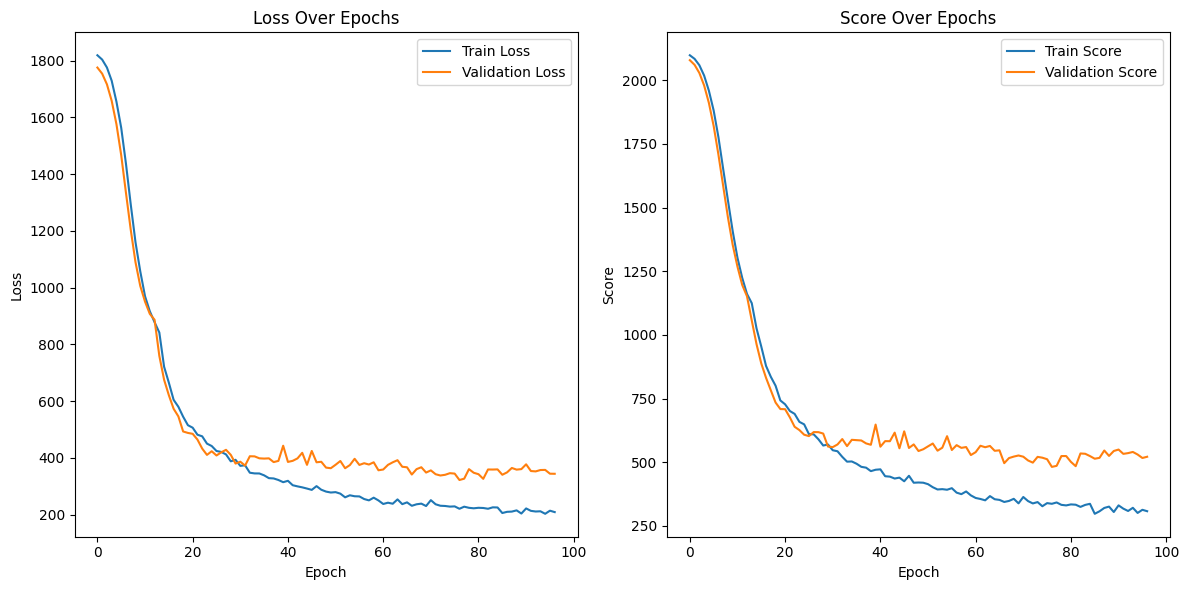

In [27]:
# Create DataFrames
train_loss_df = pd.DataFrame({"epoch": range(len(history_train_loss)), "loss": history_train_loss})
val_loss_df = pd.DataFrame({"epoch": range(len(history_val_loss)), "loss": history_val_loss})

train_score_df = pd.DataFrame({"epoch": range(len(history_train_score)), "score": history_train_score})
val_score_df = pd.DataFrame({"epoch": range(len(history_val_score)), "score": history_val_score})

# Plot loss and score
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted figure size

# Loss plot
sns.lineplot(data=train_loss_df, x="epoch", y="loss", label="Train Loss", ax=ax[0])
sns.lineplot(data=val_loss_df, x="epoch", y="loss", label="Validation Loss", ax=ax[0])
ax[0].set_title("Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Score plot
sns.lineplot(data=train_score_df, x="epoch", y="score", label="Train Score", ax=ax[1])
sns.lineplot(data=val_score_df, x="epoch", y="score", label="Validation Score", ax=ax[1])
ax[1].set_title("Score Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Score")
ax[1].legend()

plt.tight_layout()
plt.show()

<ipython-input-22-2c37e7c2c2c3>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/intermediate-fusion-house-price/pytorch/def

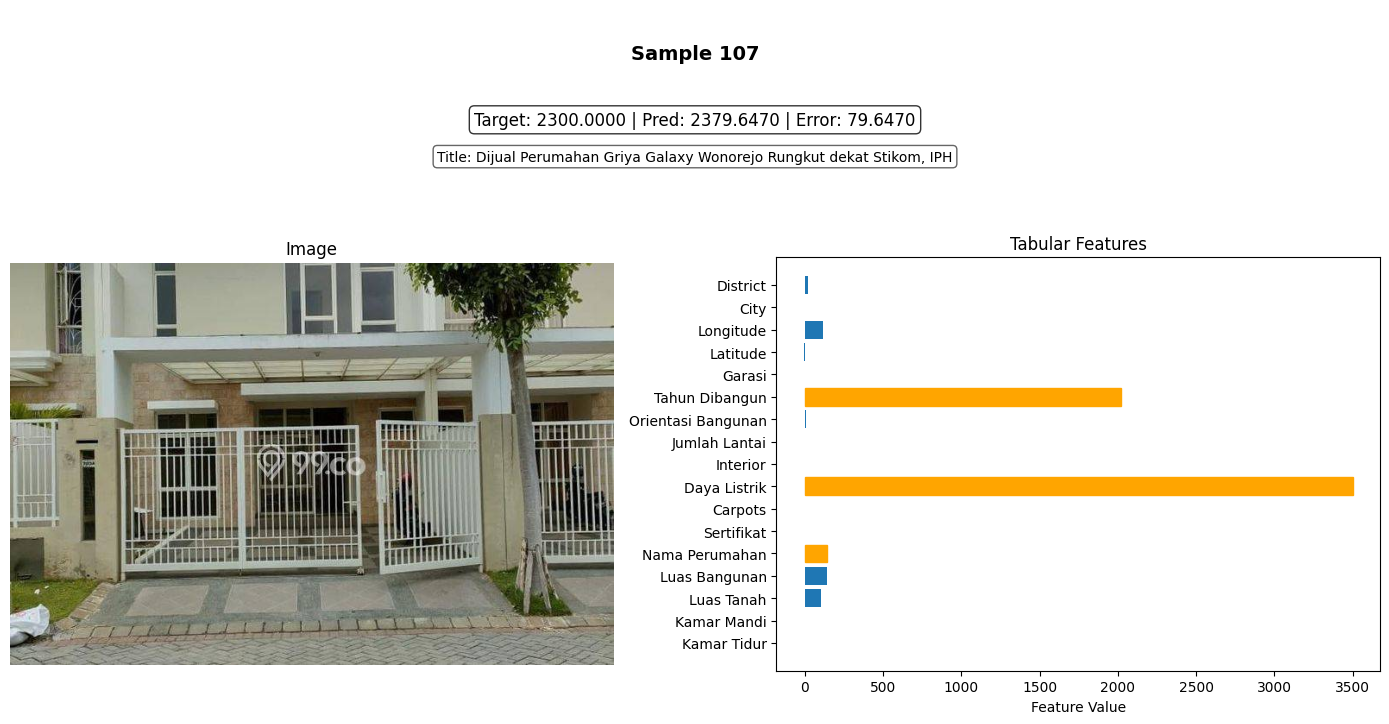

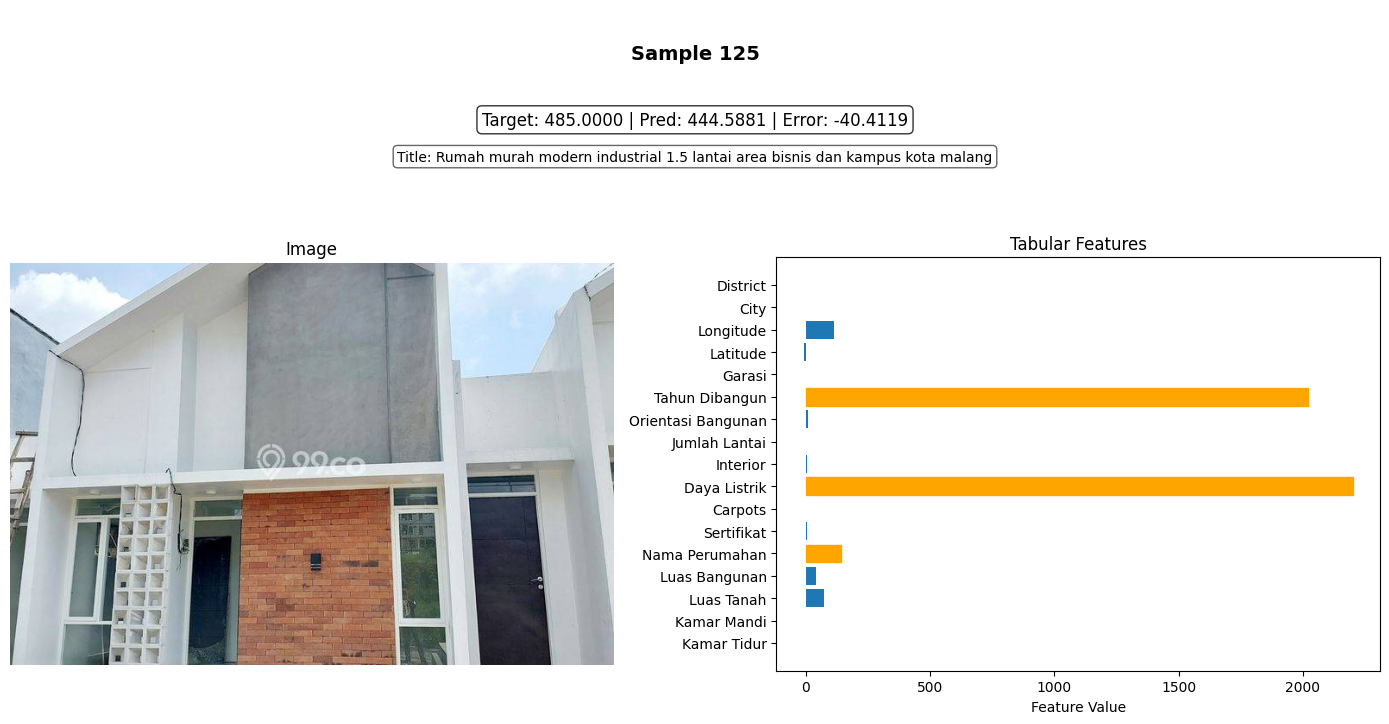

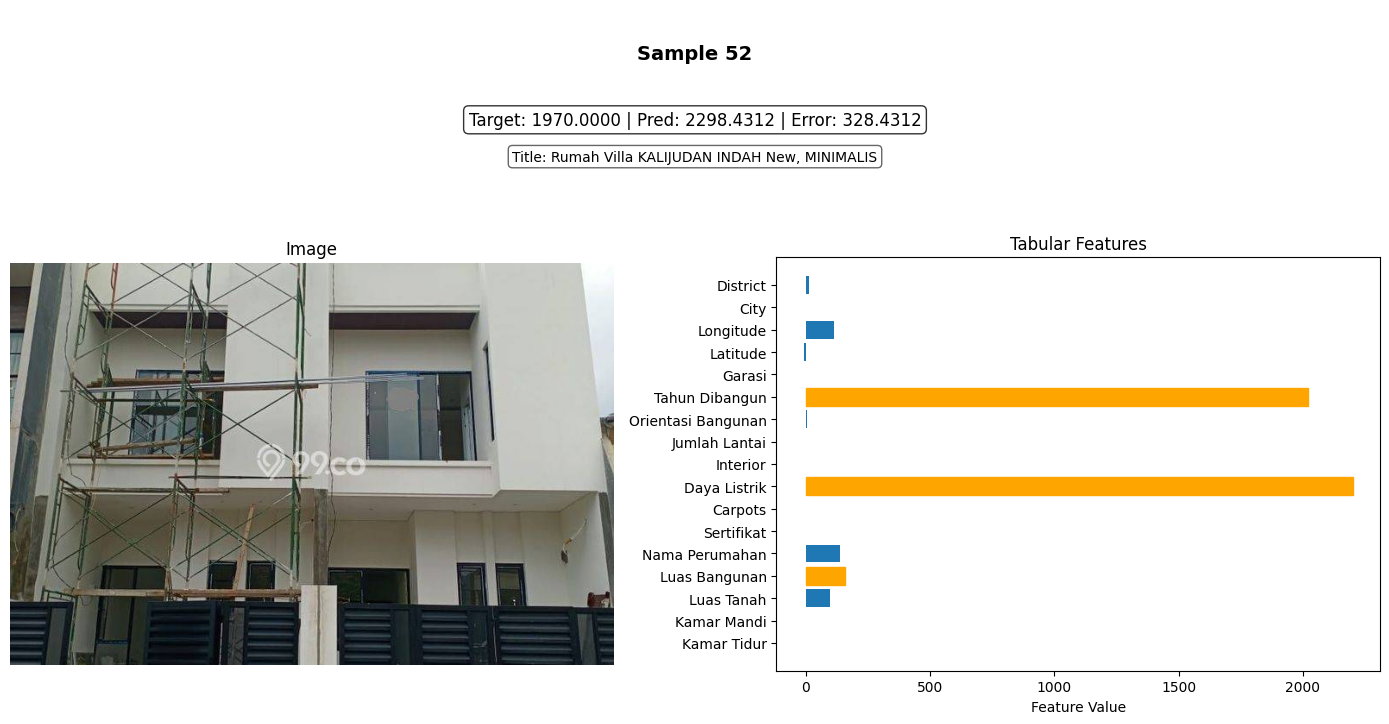

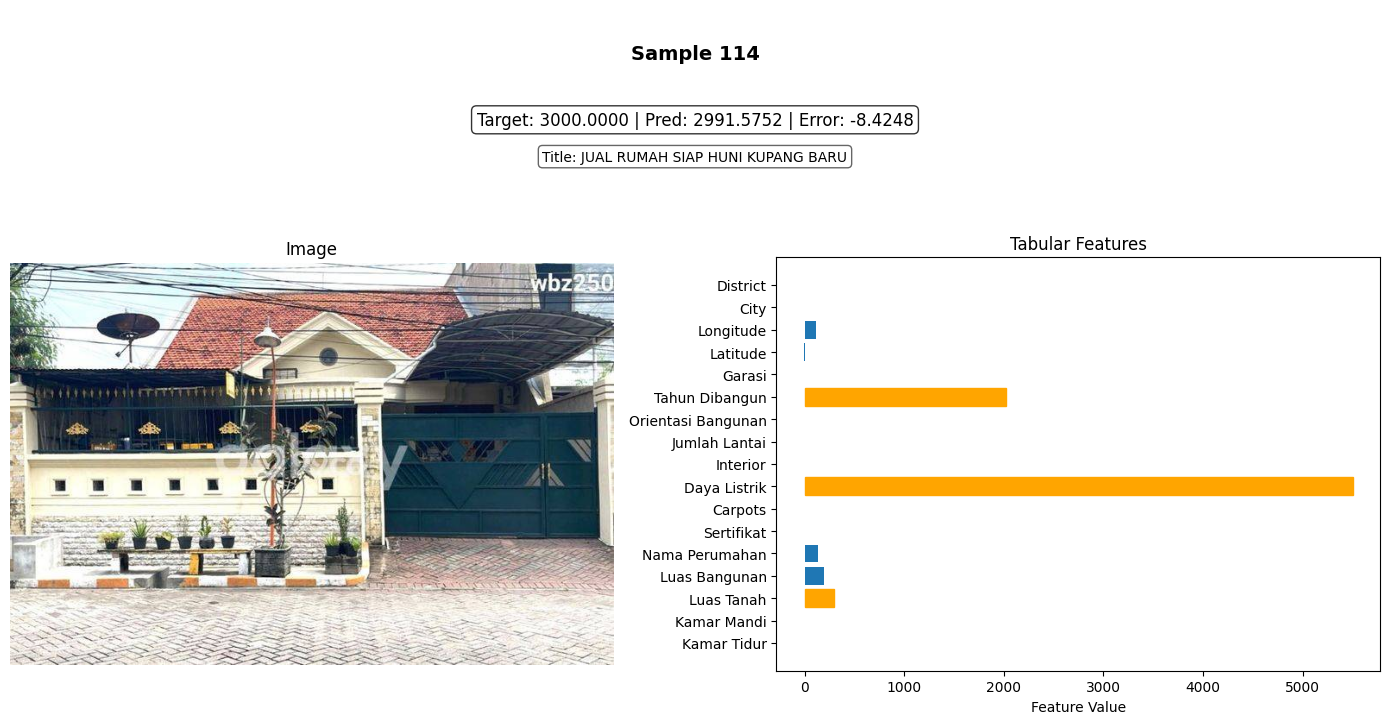

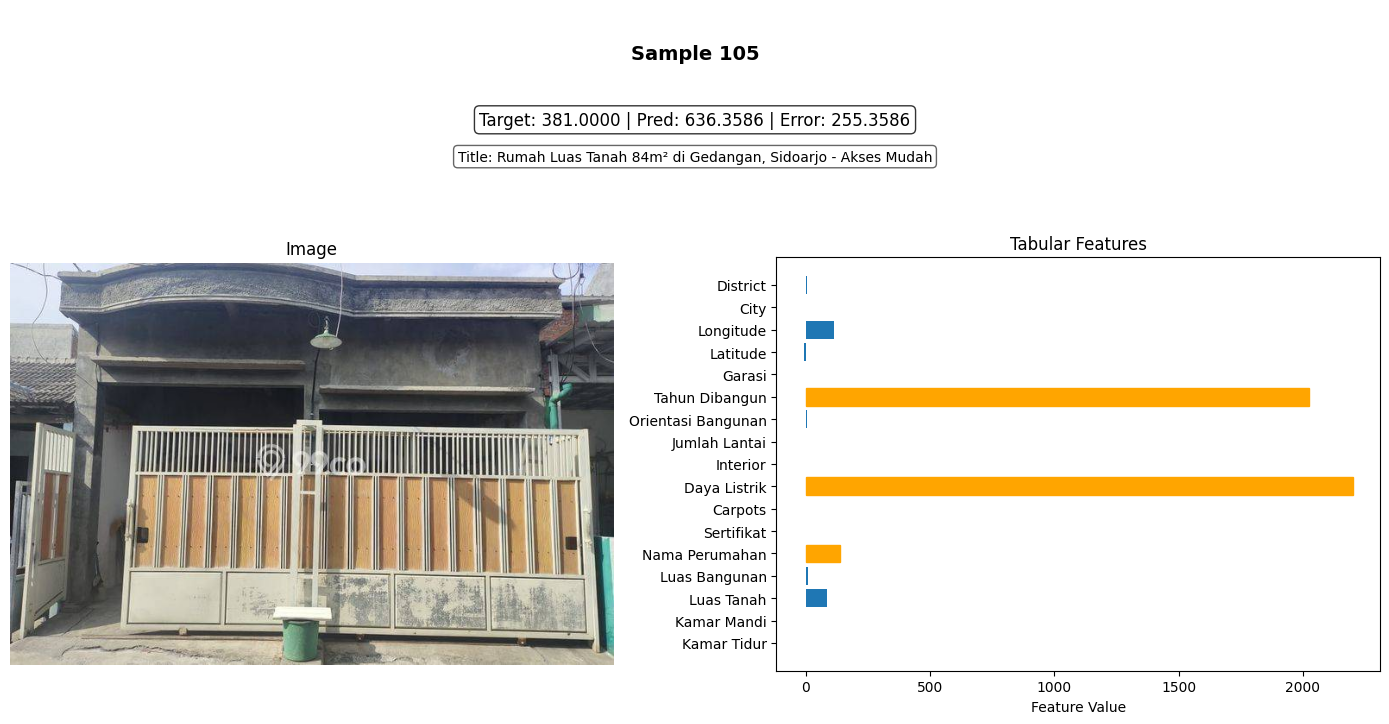

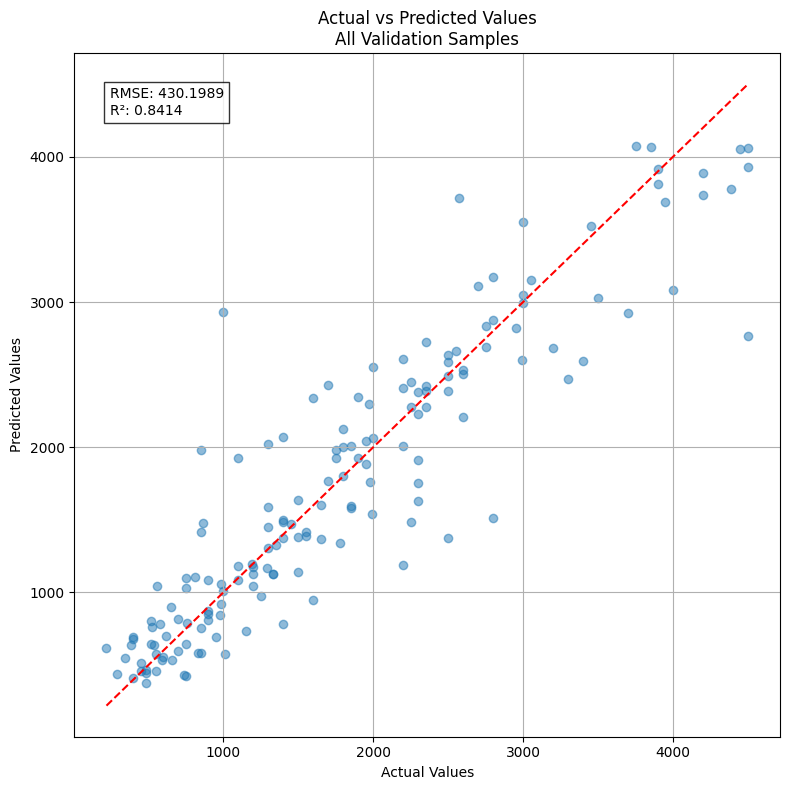

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from matplotlib.gridspec import GridSpec

def visualize_sample(index, image_path, tabular_data, text_data, target, prediction, feature_names=None):
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(3, 4, figure=fig)  # 3 rows x 4 columns

    # Left: Image spans middle and bottom rows
    ax_img = fig.add_subplot(gs[1:, 0:2])
    try:
        kaggle_path = '/kaggle/input/house-price-multimodal-dataset'
        img = Image.open(os.path.join(kaggle_path, image_path))
        ax_img.imshow(img)
    except Exception:
        ax_img.text(0.5, 0.5, f"Image not found\n{image_path}", ha='center', va='center')
    ax_img.axis('off')
    ax_img.set_title("Image")

    # Right: Tabular data bar chart spans middle and bottom rows
    ax_bar = fig.add_subplot(gs[1:, 2:])
    if feature_names is None:
        feature_names = [f'Feat {i}' for i in range(len(tabular_data))]
    bars = ax_bar.barh(feature_names, tabular_data)
    ax_bar.set_title("Tabular Features")
    ax_bar.set_xlabel("Feature Value")
    top_features = np.argsort(np.abs(tabular_data))[-3:]
    for i in top_features:
        bars[i].set_color('orange')

    # Center Top: Prediction + Actual + Error
    ax_pred_info = fig.add_subplot(gs[0, 1:3])
    ax_pred_info.axis('off')
    ax_pred_info.text(0.5, 0.7, f"Sample {index}", ha='center', fontsize=14, weight='bold')
    ax_pred_info.text(0.5, 0.3, 
                      f"Target: {target:.4f} | Pred: {prediction:.4f} | Error: {prediction - target:.4f}", 
                      ha='center', fontsize=12,
                      bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

    # Center just below prediction info: Text summary (title)
    ax_text = fig.add_subplot(gs[1, 1:3])
    ax_text.axis('off')
    ax_text.text(0.5, 1.65, 
                 f"Title: {text_data[:80]}{'...' if len(text_data) > 80 else ''}", 
                 ha='center', va='top', wrap=True,
                 bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.5)
    plt.show()

# Load the best model
model.load_state_dict(torch.load('/kaggle/input/intermediate-fusion-house-price/pytorch/default/1/best_model.pth'))
model = model.to(device)
model.eval()

# Get feature names from your tabular data
feature_names = X_train_tab.columns.tolist()

# Select samples to visualize
num_samples_to_show = 5
sample_indices = np.random.choice(len(X_val), num_samples_to_show, replace=False)

for idx in sample_indices:
    # Get data from validation set
    image_path = X_val.iloc[idx]['images_path']
    tabular_features = X_val_tab.iloc[idx].values
    text_data = X_val.iloc[idx]['Title']
    target_value = y_val.iloc[idx]
    
    # Prepare model inputs
    tabular_tensor = torch.tensor(tabular_features, dtype=torch.float32).unsqueeze(0).to(device)
    
    # You'll need to preprocess image and text the same way as in your Dataset
    # For simplicity, I'm assuming your val_dataset handles this
    with torch.no_grad():
        # Get the preprocessed data from your Dataset
        tabular, image, text, _ = val_dataset[idx]
        
        # Get prediction
        pred = model(
            tabular.unsqueeze(0).to(device),
            image.unsqueeze(0).to(device),
            text.unsqueeze(0).to(device)
        ).item()
    
    visualize_sample(
        index=idx,
        image_path=image_path,
        tabular_data=tabular_features,
        text_data=text_data,
        target=target_value,
        prediction=pred,
        feature_names=feature_names
    )

# Additional: Plot predictions vs actual for all validation samples
plt.figure(figsize=(8, 8))
all_preds = []
all_targets = []

with torch.no_grad():
    for tabular, image, text, target in val_loader:
        tabular = tabular.to(device)
        image = image.to(device)
        text = text.to(device)
        output = model(tabular, image, text)
        all_preds.extend(output.cpu().numpy().flatten())
        all_targets.extend(target.cpu().numpy())

plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values\nAll Validation Samples')

# Add RMSE and R-squared
rmse = np.sqrt(np.mean((np.array(all_preds) - np.array(all_targets))**2))
r2 = 1 - np.sum((np.array(all_preds) - np.array(all_targets))**2) / np.sum((np.array(all_targets) - np.mean(all_targets))**2)
plt.text(0.05, 0.95, f'RMSE: {rmse:.4f}\nR²: {r2:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True)
plt.tight_layout()
plt.show()

# Save Processor

In [23]:
# Save processor alongside model
image_processor.save_pretrained("model_assets/dinov2_processor")

['model_assets/dinov2_processor/preprocessor_config.json']

In [24]:
tokenizer.save_pretrained("model_assets/e5_processor")

('model_assets/e5_processor/tokenizer_config.json',
 'model_assets/e5_processor/special_tokens_map.json',
 'model_assets/e5_processor/sentencepiece.bpe.model',
 'model_assets/e5_processor/added_tokens.json',
 'model_assets/e5_processor/tokenizer.json')

In [19]:
import pickle

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [23]:
scaler.feature_names_in_

array(['Kamar Tidur', 'Kamar Mandi', 'Luas Tanah', 'Luas Bangunan',
       'Nama Perumahan', 'Sertifikat', 'Carpots', 'Daya Listrik',
       'Interior', 'Jumlah Lantai', 'Orientasi Bangunan',
       'Tahun Dibangun', 'Garasi', 'Latitude', 'Longitude', 'City',
       'District'], dtype=object)